In [16]:
from random import random
import numpy as np
from itertools import product
from math import sqrt
import matplotlib.pyplot as plt

class Det_Game:    
    def __init__(self, action_list, cost_list):
        self.cost_list = cost_list
        self.agent_actions = self.initialize_actions(action_list)
        self.agent_weights = self.initialize_weights(self.agent_actions)
        All_Strategy = list(product(*[i for i in action_list]))
        self.action_to_cost = self.initialize_actions_cost(All_Strategy, cost_list)
        
    def initialize_weights(self,agent_actions_dict):
        agent_weights = {}
        for agent_name,strategy in agent_actions_dict.items():
            agent_weights[agent_name] = np.ones(len(strategy)) +np.array([0.2,0.1])#+ np.random.normal(0,0.1, size=len(strategy))
            # Cannot start with 1, 1 ,1 weight, otherwise it will get stuck in the MNE already
#             agent_weights[agent_name] = np.array([1,2])
        return agent_weights
    def get_agent_actions(self):
        return self.agent_actions

    
    def initialize_actions(self,agent_actions_list):
        agent_actions = {}
        agent_counter = 1
        for actions in agent_actions_list:
            agent_actions['agent{}'.format(agent_counter)] = actions
            agent_counter +=1
        return agent_actions        

    def initialize_actions_cost(self,All_Strategy, cost_list):
        """cost_list should be input row by row"""
        self.action_to_cost = {}
        flat_cost_list = [item for sublist in cost_list for item in sublist]
        for strategy, cost in zip(All_Strategy,flat_cost_list):
            self.action_to_cost[strategy] = cost
        return self.action_to_cost
    
    def get_action_to_cost(self):
        return self.action_to_cost

    def action(self,probability_distribution):
        return np.random.choice(len(probability_distribution),1,p=probability_distribution)[0] # [0] unwarp the array

    def get_action(self,agent, agent_weights):
        total = sum(agent_weights[agent])
        num_actions = len(agent_weights[agent])
        agent_p = [agent_weights[agent][i]/total for i in range(num_actions)]
        debug_agent_p1 = agent_weights[agent][1]/total
        agent_a = self.action(agent_p)
    #     print('probability of action1 = {}'.format(agent_p))
    #     print('probability of action2 = {}'.format(debug_agent_p1))
    #     print(agent_weights[agent])

        return agent_a, agent_p  

    def get_cost_vector(self, agent, opponent_p, agent_actions, action_to_cost):
#         print("debug agent_actions = ", agent_actions)
        if agent == 'agent1':
            num_actions = len(agent_actions[agent])
            cost_vector = []
            action_vector = [[tuple([agent_actions['agent1'][i],agent_actions['agent2'][j]]) for j in range(num_actions)] for i in range(num_actions)]
            # Now assume 2 agents have the same number of strategy
            action_vector = np.array([list(map(action_to_cost.get, a)) for a in action_vector])[:,:,0]
            for a in action_vector:
                cost_vector.append(np.sum(a*opponent_p)) # 0 means agent1
        else:
            num_actions = len(agent_actions[agent])
            action_vector = [[tuple([agent_actions['agent1'][j],agent_actions['agent2'][i] ]) for j in range(num_actions)] for i in range(num_actions)]
            action_vector = np.array([list(map(action_to_cost.get, a)) for a in action_vector])[:,:,1]
            cost_vector = []
            for a in action_vector:
                cost_vector.append(np.sum(a*opponent_p))
        return np.array(cost_vector)

    def print_game(self):
        pass
        
    def MWU(self,iterations, epsilon=0.05, new_ep=lambda ep, t:ep): 
        epsilon_history = []
        num_actions1 = len(self.agent_weights['agent1'])
        num_actions2 = len(self.agent_weights['agent2'])
        
        agent1_sum = sum(self.agent_weights['agent1'])
        agent2_sum = sum(self.agent_weights['agent2'])
        
        self.agent1_cost_vector_history = []
        self.agent2_cost_vector_history = []
        
        self.agent1_p_history = [] # This is probability distribution without the last one ()
        self.agent2_p_history = [] 

        counter = 1
        for i in range(iterations):
    #         print('playing game round {}'.format(counter))
            agent1_a, agent1_p = self.get_action('agent1',self.agent_weights)
            agent2_a, agent2_p = self.get_action('agent2',self.agent_weights)
#             print("weight vector = ",self.agent_weights['agent1'])
            cost_vector1 = self.get_cost_vector('agent1', agent2_p, self.agent_actions, self.action_to_cost)
            cost_vector2 = self.get_cost_vector('agent2', agent1_p, self.agent_actions, self.action_to_cost)
            epsilon = new_ep(epsilon, i+1)
            epsilon_history.append(epsilon)
            self.agent_weights['agent1'] = self.agent_weights['agent1']*(1-epsilon)**cost_vector1
            self.agent_weights['agent2'] = self.agent_weights['agent2']*(1-epsilon)**cost_vector2    

            agent1_sum = sum(self.agent_weights['agent1'])
            agent2_sum = sum(self.agent_weights['agent2'])
            
            # Appending agent information
            self.agent1_cost_vector_history.append(cost_vector1)
            self.agent2_cost_vector_history.append(cost_vector2)

            self.agent1_p_history.append(agent1_p)
            self.agent2_p_history.append(agent2_p)

            counter+=1
        print("Training for {} steps is done".format(counter-1))
        return epsilon_history
#         print('outputing {} strategies for agent1'.format(num_actions1))
#         print('outputing {} strategies for agent2'.format(num_actions2))
#         return self.agent1_history, self.agent2_history
    def plot(self):
        fontsize = 16
        fontsize_title = 20
        fig, ax = plt.subplots(1,2,figsize=(16,5))
        ax[0].set_title('agent1', fontsize=fontsize_title)
        ax[1].set_title('agent2', fontsize=fontsize_title)
        ax[0].set_xlabel('step', fontsize=fontsize)
        ax[1].set_xlabel('step', fontsize=fontsize)
        ax[0].set_ylabel('Probability of choosing certain action', fontsize=fontsize)
        ax[1].set_ylabel('Probability of choosing certain action', fontsize=fontsize)    

        ax[0].plot(self.agent1_p_history)
        ax[1].plot(self.agent2_p_history)

        ax[0].legend([s for s in self.agent_actions['agent1']])
        ax[1].legend([s for s in self.agent_actions['agent2']])
        
    def show_game(self):
        return pd.DataFrame(self.cost_list,columns=self.agent_actions['agent2'], index=self.agent_actions['agent1'])
    #     agent_weights['agent1'][0]/agent1_sum, agent_weights['agent1'][1]/sum(agent_weights['agent1']), agent_weights['agent2'][0]/sum(agent_weights['agent2']), agent_weights['agent2'][1]/sum(agent_weights['agent2'])
    def get_history(self):
#         print(len(self.agent1_history))
#         print(len(self.agent2_history))
        return [self.agent1_history, self.agent2_history]

    def get_agent_p_history(self):
#         print(len(self.agent1_history))
#         print(len(self.agent2_history))
        return [self.agent1_p_history, self.agent2_p_history]

    def get_cost_history(self):
#         print(len(self.agent1_history))
#         print(len(self.agent2_history))
        return [self.agent1_cost_vector_history, self.agent2_cost_vector_history]

    
    def plot_scatter(self):
        fontsize = 16
        plt.figure(figsize=(8,8))
        plt.scatter(np.array(self.agent1_p_history)[:,0], np.array(self.agent2_p_history)[:,0])
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xlabel('Probability of Agent 1 playing Strategy 1', fontsize=fontsize)
        plt.ylabel('Probability of Agent 2 playing Strategy 1', fontsize=fontsize)
        plt.tick_params(labelsize=20)

Training for 2000 steps is done


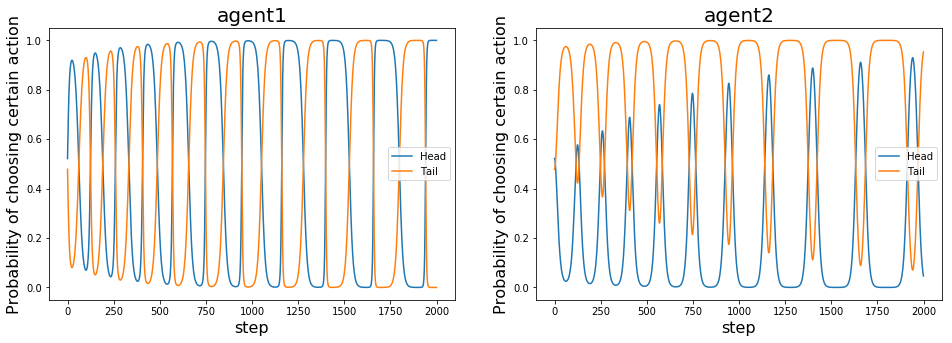

In [24]:
action_list = [['Head', 'Tail'],['Head', 'Tail']]
cost_list = [[[-7,1],[1,-1]],[[1,-1],[-1,1]]]
Matching = Det_Game(action_list, cost_list)
history = Matching.MWU(2000, new_ep=lambda ep, t:0.05)
Matching.plot()

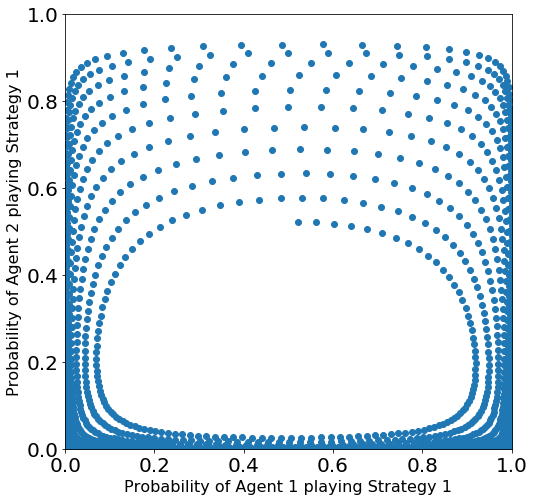

In [25]:
Matching.plot_scatter()

In [27]:
history = Matching.get_agent_p_history()

In [28]:
np.average(history[0])

0.5

In [29]:
np.average(history[1])

0.5

In [19]:
p_history = Matching.get_agent_p_history()
cost_list = [[-1,1],[1,-1]],[[1,-1],[-1,1]]

In [256]:
agent1_p_history = p_history[0]
agent2_p_history = p_history[1]

In [257]:
agent_action = Matching.get_agent_actions()

In [258]:
def calculate_regret(agent_num, agent1_p_history, agent2_p_history):
    def get_daily_cost():
        # Calculating first component \sum_{t=1}^{T}c^t(a^t)
        Expected_cost = 0
        Daily_Regret_Avg_history = [] 
        Acc_Cost = []

        for day in range(1,len(agent1_p_history)):
            for i in range(len(agent_action['agent1'])):
                for j in range(len(agent_action['agent2'])):
                    Expected_cost += agent1_p_history[day-1][i]*agent2_p_history[day-1][j]*cost_list[i][j][agent_num] # index 0 for agent 1
                    # There's inifite many distribution for the best option. So we choose pure strategy instead
            #print(Expected_cost)
            Acc_Cost.append(Expected_cost)

        return Acc_Cost    

    def get_best_hindsight_cost():
        Expected_best_cost = 0
        Daily_Regret_Avg_history = [] 
        Acc_Best_Cost = []
        Best_Strategy = [[1,0],[0,1]]

        for Pure_Strategy in Best_Strategy:
            temp_list = []
            for day in range(1,len(agent1_p_history)):
                for i in range(len(agent_action['agent1'])):
                    for j in range(len(agent_action['agent2'])):
                        Expected_best_cost += Pure_Strategy[i]*agent2_p_history[day-1][j]*cost_list[i][j][agent_num] # index 0 for agent 1
                        # There's inifite many distribution for the best option. So we choose pure strategy instead
                #print(Expected_cost)
                temp_list.append(Expected_best_cost)

            Acc_Best_Cost.append(temp_list)
            action = np.argmin(np.sum(Acc_Best_Cost, axis=1))
            return Acc_Best_Cost[action]    
        
    return np.array(get_daily_cost())-np.array(get_best_hindsight_cost())

Text(0.5, 1.0, 'Total Regret')

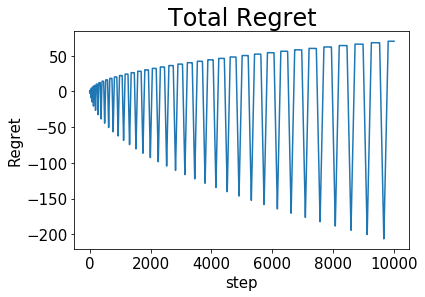

In [259]:
plt.plot(calculate_regret(0, agent1_p_history, agent2_p_history))
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel('step', fontsize=15)
plt.ylabel('Regret', fontsize=15) 
plt.title('Total Regret', fontsize=24)

Text(0.5, 1.0, 'Time Averaged Regret')

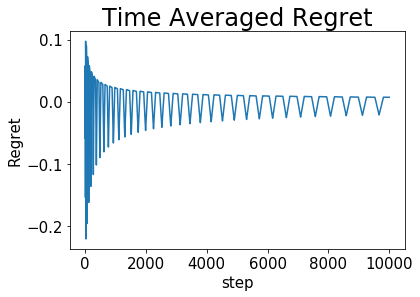

In [260]:
plt.plot(calculate_regret(0, agent1_p_history, agent2_p_history)/Day_array)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel('step', fontsize=15)
plt.ylabel('Regret', fontsize=15) 
plt.title('Time Averaged Regret', fontsize=24)

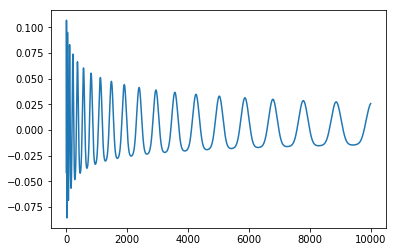

In [248]:
plt.plot(calculate_regret(1, agent1_p_history, agent2_p_history)/Day_array)

In [231]:
Day_array = np.arange(len(Acc_Best_Cost))+1

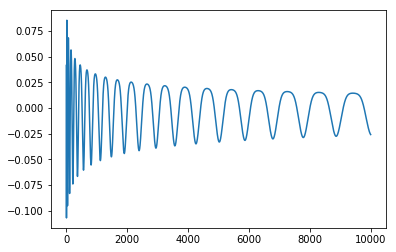

In [240]:
plt.plot((np.array(get_daily_cost())-np.array(get_best_hindsight_cost()))/Day_array)

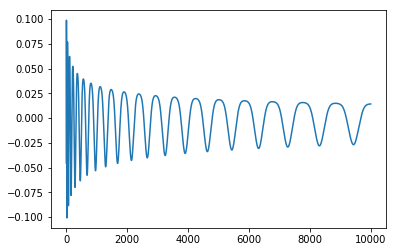

In [187]:
plt.plot((Acc_Cost - Acc_Best_Cost)/Day_array)

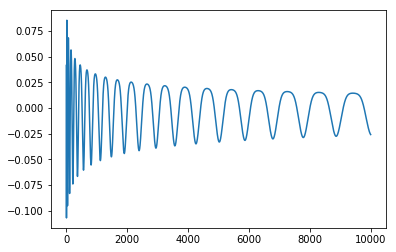

In [180]:
plt.plot((Acc_Cost - Acc_Best_Cost)/Day_array)

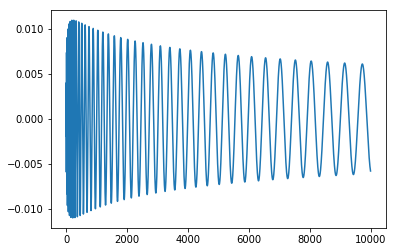

In [181]:
plt.plot(Acc_Cost/Day_array)

In [67]:
agent1_p_history

[[0.5217391304347826, 0.47826086956521746],
 [0.5564983046384103, 0.4435016953615896],
 [0.5455785679018881, 0.45442143209811187],
 [0.5084855717940646, 0.49151442820593544],
 [0.463759921427804, 0.5362400785721959],
 [0.42361502937256695, 0.5763849706274331],
 [0.3944591587436716, 0.6055408412563283],
 [0.37856457266453236, 0.6214354273354676],
 [0.3758534053490144, 0.6241465946509857],
 [0.3851088236212077, 0.6148911763787924],
 [0.40454671335248726, 0.5954532866475127],
 [0.43200768123564676, 0.5679923187643532],
 [0.46504195849238567, 0.5349580415076143],
 [0.5010457871927706, 0.4989542128072295],
 [0.5374784672471067, 0.46252153275289326],
 [0.572100168124073, 0.427899831875927],
 [0.603147967977768, 0.396852032022232],
 [0.6294015835513572, 0.3705984164486428],
 [0.6501431231990471, 0.34985687680095284],
 [0.6650512246991502, 0.33494877530084977],
 [0.6740772691528042, 0.3259227308471959],
 [0.6773388703613175, 0.3226611296386825],
 [0.6750477416037833, 0.32495225839621666],
 [0.

In [30]:
agent2_p_history[0]

[0.5217391304347826, 0.47826086956521746]

In [31]:
Matching.get_action_to_cost()

{('Head', 'Head'): [-1, 1],
 ('Head', 'Tail'): [1, -1],
 ('Tail', 'Head'): [1, -1],
 ('Tail', 'Tail'): [-1, 1]}

In [34]:
action_dict = Matching.get_action_to_cost()